The RandomizedLogisticRegression is not stable between kernels.
Just create a notebook and do all the analysis + print output to files,
So yoiu won't have problem on making the figures

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Read HDF file and phenotypes

In [3]:
final_SNPs = pd.read_hdf('data/BeanCAP_MDP_genotype_data.hdf5', 'snptable')
pheno_all = pd.read_csv('data/Adjusted-means-for-Agronomic-traits-with-race-and-market-calss-info.txt',
                       sep = '\t', header=0)
pheno_all.head()

,supop,market_class,taxa,df_co,dm_co,ch_co,lg_co,gh_co,sw_co,df_mi,...,dm_ne,ch_ne,lg_ne,sw_ne,df,dm,ch,lg,gh,sw
0,MA,black,115m,49,92,50,4,2,20.0,41,...,96,41,4,20.5,49,102,45,3.67,2.5,21.5
1,DJ,pink,6r_42,46,90,41,5,3,29.9,38,...,101,40,5,30.5,47,103,37,5.00,3.0,32.3
2,MA,black,92bg_7,49,87,48,3,3,22.8,44,...,79,33,2,21.7,50,92,39,2.33,2.5,21.7
3,DJ,pinto,92us_1006,46,82,45,1,2,30.3,38,...,78,45,1,29.2,45,90,43,1.33,2.0,31.3
4,MA,cream_caroca,a_285,51,94,55,3,3,22.2,45,...,95,40,3,20.9,52,103,48,3.00,2.5,23.1


Since it is the first analysis I will do some data exploration

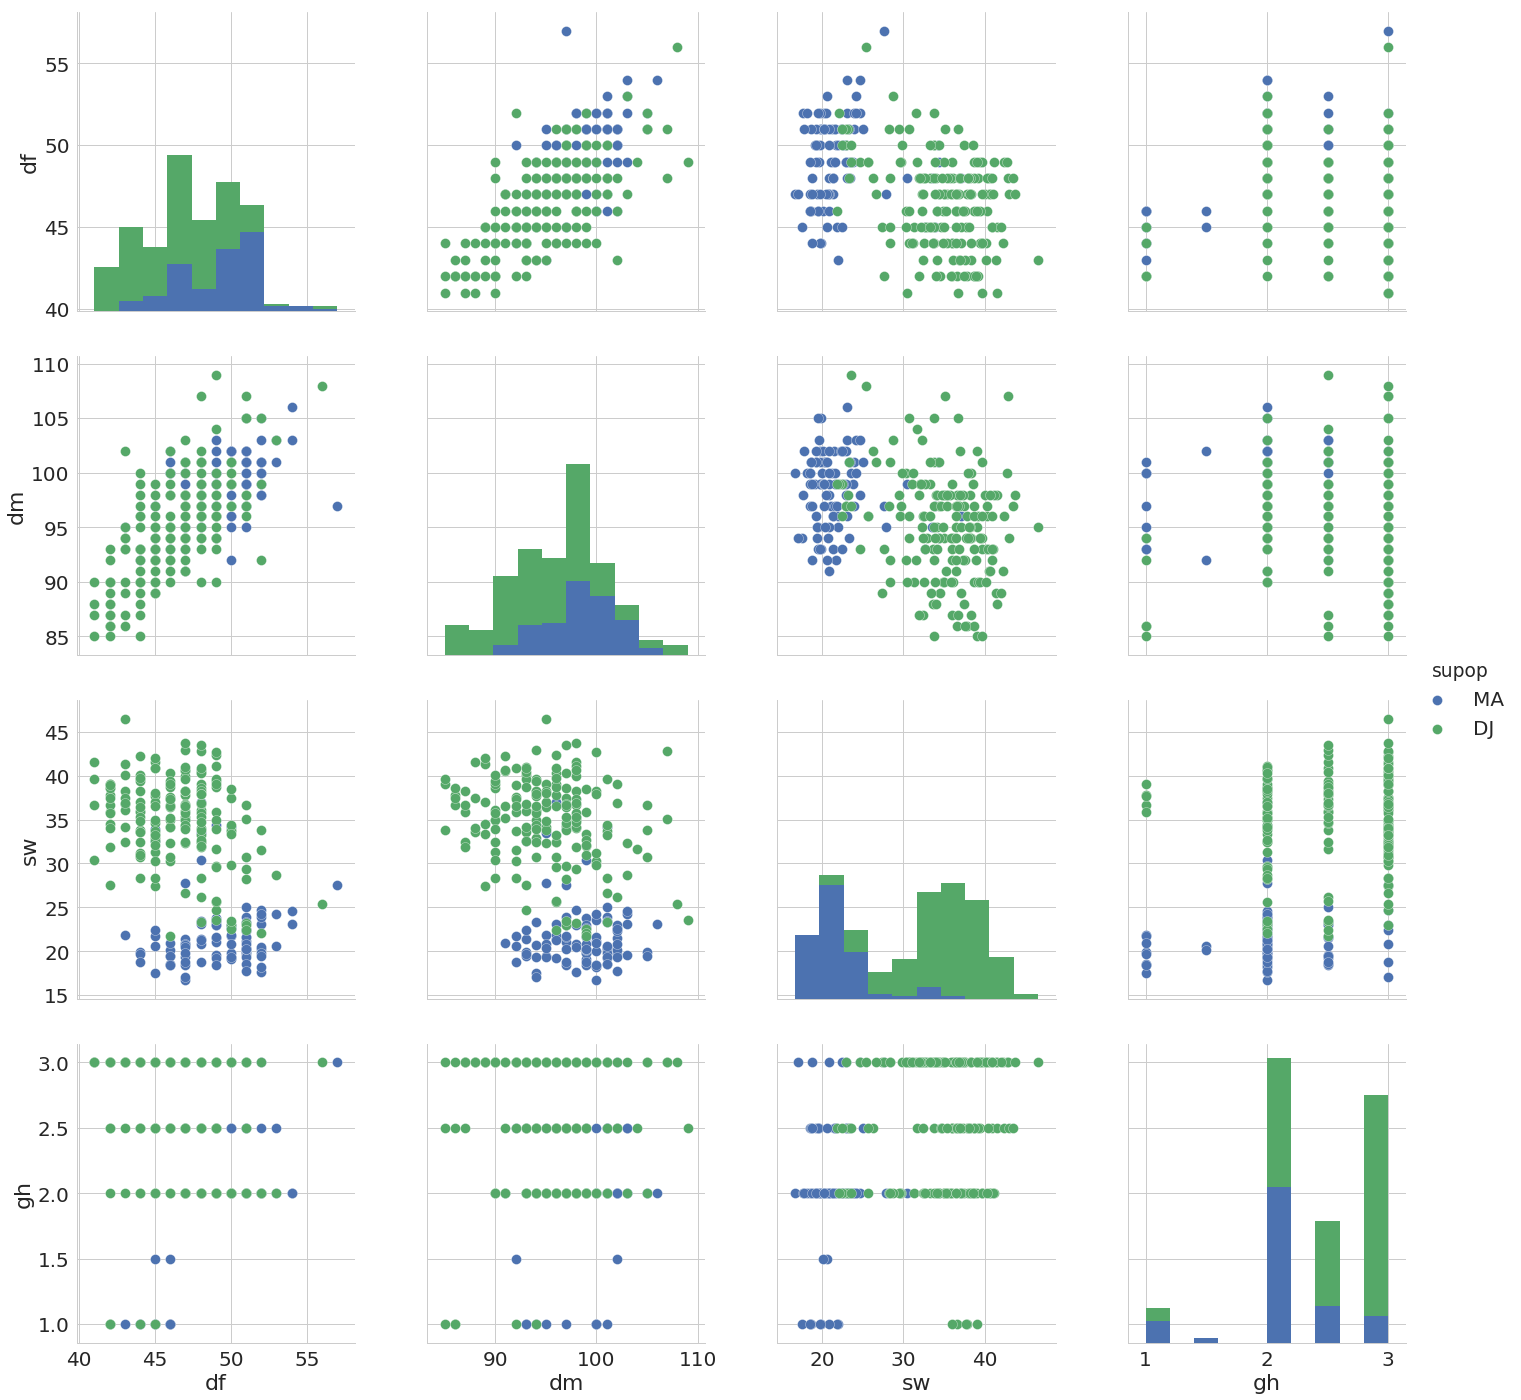

In [4]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.pairplot(pheno_all[['df', 'dm', 'sw', 'gh', 'supop']], hue='supop', size=5, 
             plot_kws={'s':100});

### 3 class plots

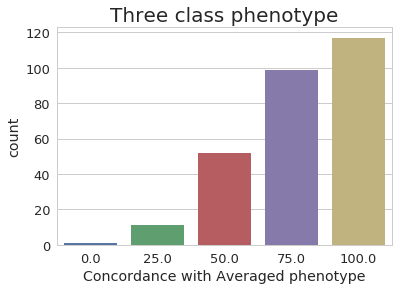

In [5]:
def multi_class(dataframe):
    l=[]
    for i in dataframe.columns:
        l.append(pd.qcut(dataframe[i], q=[0,.25, .75, 1], labels = False))
    return l

df_data = pheno_all[['df', 'df_co', 'df_mi','df_ne', 'df_nd']]
cl = multi_class(df_data)
cl_data = pd.DataFrame(cl).T
#sns.heatmap(cl_data)

avg = cl_data['df']
cl_data2 = cl_data.drop('df', axis=1)

l = []
for i in cl_data2.columns:
    l.append(cl_data2[i]==avg)
    
    
    
def get_perc(i):
    return (np.sum(i)/4)*100

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
new = pd.DataFrame(l).T
x = new.apply(get_perc, axis=1)
sns.countplot(x)
plt.title('Three class phenotype', fontsize=20)
plt.xlabel('Concordance with Averaged phenotype');
    


### Early

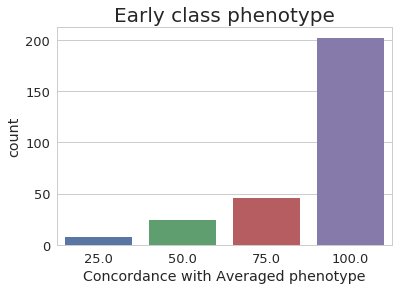

In [6]:
def multi_class(dataframe):
    l=[]
    for i in dataframe.columns:
        l.append(pd.qcut(dataframe[i], q=[0,.25, 1], labels = False))
    return l

df_data = pheno_all[['df', 'df_co', 'df_mi','df_ne', 'df_nd']]
cl = multi_class(df_data)
cl_data = pd.DataFrame(cl).T
#sns.heatmap(cl_data)

avg = cl_data['df']
cl_data2 = cl_data.drop('df', axis=1)

l = []
for i in cl_data2.columns:
    l.append(cl_data2[i]==avg)
    
    
    
def get_perc(i):
    return (np.sum(i)/4)*100

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
new = pd.DataFrame(l).T
x = new.apply(get_perc, axis=1)
sns.countplot(x)
plt.title('Early class phenotype', fontsize=20)
plt.xlabel('Concordance with Averaged phenotype');
    

### Late

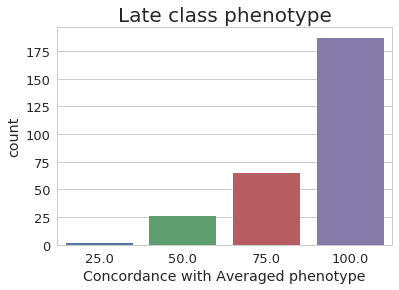

In [7]:
def multi_class(dataframe):
    l=[]
    for i in dataframe.columns:
        l.append(pd.qcut(dataframe[i], q=[0,.75, 1], labels = False))
    return l

df_data = pheno_all[['df', 'df_co', 'df_mi','df_ne', 'df_nd']]
cl = multi_class(df_data)
cl_data = pd.DataFrame(cl).T
#sns.heatmap(cl_data)

avg = cl_data['df']
cl_data2 = cl_data.drop('df', axis=1)

l = []
for i in cl_data2.columns:
    l.append(cl_data2[i]==avg)
    
    
    
def get_perc(i):
    return (np.sum(i)/4)*100

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
new = pd.DataFrame(l).T
x = new.apply(get_perc, axis=1)
sns.countplot(x)
plt.title('Late class phenotype', fontsize=20)
plt.xlabel('Concordance with Averaged phenotype');
    

# All collection

Prepare phenotypes and genotypes for ML training

I will use the cross_val_score with **scorer='precision_micro'** for the classification. Then I will plot two graphs (1 DF and 1 DM) with mean +- std of the cv values (use 5 cv)

Create funcion with all the data in the model_prescreen script. N.B. for precision you should use a `make_scorer(precision_score, average=average)` like for precision_recall curve.
return a dataframe with all the prediction x classifier, so you can plot it with seaborn point_plot

I will analyze
1. Early (25 %)
2. Late (75 %)
3. 3 Classes

In [5]:
# import custom module
from model_prescreen import classification_task_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.metrics import make_scorer, precision_score

## Feature selection approach

In [9]:
def feature_selector(X,y, k):
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X,y)
    return selector

#def feature_selector(X,y,model):
#    model.fit(X,y)
#    selector = SelectFromModel(model,threshold = 0.00001, prefit=True)
#    return selector

## Stratify byclass

## Early 25%

In [10]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)



X_train_s = feature_selector(X_train, y_train, k=2000).transform(X_train)

early_prec = make_scorer(precision_score, average='binary', pos_label=0)
print(X_train_s.shape)
classification_prescreen_early = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer=early_prec,
                                                           cv = 5, jobs=7)

(224, 2000)
Processing KNeighbors model 1 of 9
Processing SVC model 2 of 9
Processing RandomForest model 3 of 9
Processing LogisticRegression model 4 of 9
Processing SGD model 5 of 9
Processing MLP model 6 of 9
Processing GradientBoosting model 7 of 9
Processing Bagging model 8 of 9
Processing linearSVC model 9 of 9


## Late 25

In [11]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)


X_train_s = feature_selector(X_train, y_train, k=2000).transform(X_train)
print(X_train_s.shape)
classification_prescreen_late = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision',
                                                          cv = 5, jobs=7)

(224, 2000)
Processing KNeighbors model 1 of 9
Processing SVC model 2 of 9
Processing RandomForest model 3 of 9
Processing LogisticRegression model 4 of 9
Processing SGD model 5 of 9
Processing MLP model 6 of 9
Processing GradientBoosting model 7 of 9
Processing Bagging model 8 of 9
Processing linearSVC model 9 of 9


## 3 classes

In [12]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)


X_train_s = feature_selector(X_train, y_train, k=2000).transform(X_train)
print(X_train_s.shape)

classification_prescreen_all = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision_macro',
                                                         cv = 5, jobs=7)

(224, 2000)
Processing KNeighbors model 1 of 9
Processing SVC model 2 of 9
Processing RandomForest model 3 of 9
Processing LogisticRegression model 4 of 9
Processing SGD model 5 of 9
Processing MLP model 6 of 9
Processing GradientBoosting model 7 of 9
Processing Bagging model 8 of 9
Processing linearSVC model 9 of 9


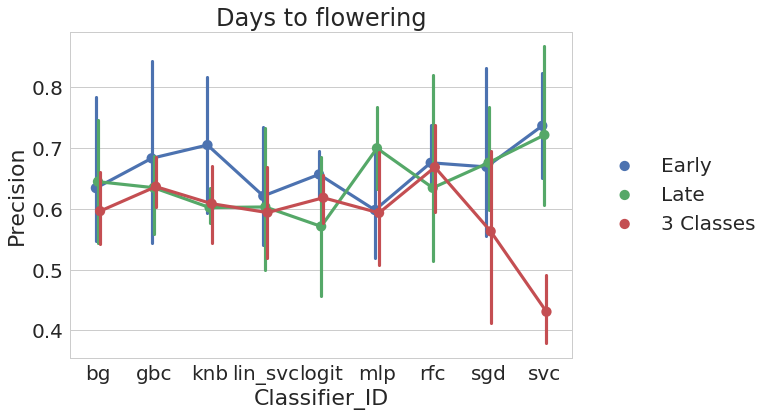

In [28]:
# plot both
sns.set(font_scale=2)
sns.set_style("whitegrid")
classification_prescreen_early['Class']=np.repeat('Early', classification_prescreen_early.shape[0])
classification_prescreen_late['Class']=np.repeat('Late', classification_prescreen_late.shape[0])
classification_prescreen_all['Class']=np.repeat('3 Classes', classification_prescreen_all.shape[0])
classification_df = pd.concat([classification_prescreen_early, 
                       classification_prescreen_late, classification_prescreen_all])


plt.figure(figsize=(9,6))
sns.pointplot(x='Classifier_ID', y='Score', hue='Class', size=100,
                   data = classification_df, dodge=True)
plt.ylabel('Precision')
plt.title('Days to flowering')
#plt.ylim((0,1))
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5));

In [29]:
# save DF to file so you can plot again later
classification_df.to_csv('CV_DF_prediction_feat_selectiong.csv', sep=',', header=True, index=False)

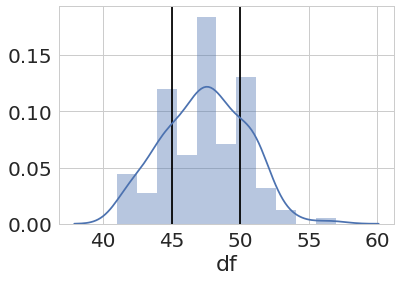

In [30]:
sns.distplot(df)
plt.vlines(np.percentile(df, 25), 0, .20)
plt.vlines(np.percentile(df, 75), 0, .20);

It seems that the best performance is achieved for 2 classes
I will try to improve the model with the 3 classes using different approaches:

1. RFC: best of the ensemble

2. Logit

3. GBC


# Prepare data-3 classes

Prepare data

In [10]:
from sklearn.metrics import precision_score, f1_score, classification_report, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

# create function for evaluatin shit
def report_res(estimator, X_train, y_train, average):
    y_pred = cross_val_predict(estimator, X_train,
                                 y_train, groups=y_train,
                                 cv = 5, n_jobs=6)
    print(precision_score(y_train, y_pred, average=average))
    print(classification_report(y_train, y_pred))
    return(y_pred)


def feature_selector(X,y, k=2000):
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X,y)
    return selector


selector = feature_selector(X_train, y_train)
X_train_s  = selector.transform(X_train)
print(X_train_s.shape)

(224, 2000)


## Random Forest

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

rf=RandomForestClassifier(oob_score=True, random_state=42)

param_dist = {'max_features':stats.uniform(0.01, 0.5),
              'n_estimators': stats.randint(10, 500),
              'min_samples_leaf':stats.randint(1, 30),
              'max_depth':stats.randint(2, 50)
             }

# before precision macro
rf_searc = RandomizedSearchCV(rf, param_distributions=param_dist,
                             iid = False, cv = 10, scoring='precision_macro', n_iter=20,
                             random_state=42, n_jobs = -1)

rf_searc.fit(X_train_s, y_train)
print(rf_searc.best_params_)
print(rf_searc.best_estimator_)

print('In sample precision: ', precision_score(y_train, rf_searc.predict(X_train_s), average='macro'))

print('CV out of sample precision :') 
y_pred= report_res(rf_searc, X_train_s, y_train, 'macro')

{'max_depth': 36, 'max_features': 0.46466020103939104, 'min_samples_leaf': 4, 'n_estimators': 59}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features=0.46466020103939104,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=59, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
In sample precision:  0.846880644234
CV out of sample precision :
0.679198668715
             precision    recall  f1-score   support

          0       0.69      0.69      0.69        62
          1       0.72      0.71      0.72       122
          2       0.62      0.65      0.63        40

avg / total       0.70      0.70      0.70       224



In [69]:
print(rf_searc.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features=0.46466020103939104,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=59, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)


In [70]:
X_test_s = selector.transform(X_test)
pred = rf_searc.predict(X_test_s)
print(precision_score(y_test, pred, average='macro'))
print(classification_report(y_test, pred))

0.763863863864
             precision    recall  f1-score   support

          0       0.89      0.50      0.64        16
          1       0.70      0.87      0.78        30
          2       0.70      0.70      0.70        10

avg / total       0.76      0.73      0.72        56



## Logit

In [59]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=42)
param_dist = {'penalty':['l1', 'l2'], 'C': stats.reciprocal(0.001, 0.1),
             'class_weight':[None, 'balanced'], 'tol':stats.expon(scale=0.1)}

lg_search = RandomizedSearchCV(lg, param_distributions=param_dist, 
                              cv=10, iid = False, scoring='precision_macro', n_iter=20,
                               random_state=42, n_jobs=-1)

lg_search.fit(X_train_s, y_train)
print(lg_search.best_params_)
print(lg_search.best_estimator_)
print('In sample precision: ', precision_score(y_train, lg_search.predict(X_train_s), average='macro'))

print('CV out of sample precision :') 
y_pred= report_res(lg_search, X_train_s, y_train, 'macro')

{'C': 0.0019010245319870352, 'class_weight': 'balanced', 'penalty': 'l2', 'tol': 0.045627721822084709}
LogisticRegression(C=0.0019010245319870352, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=42, solver='liblinear', tol=0.045627721822084709,
          verbose=0, warm_start=False)
In sample precision:  0.746510521532
CV out of sample precision :
0.638670347366
             precision    recall  f1-score   support

          0       0.63      0.71      0.67        62
          1       0.72      0.64      0.68       122
          2       0.57      0.65      0.60        40

avg / total       0.67      0.66      0.66       224



In [61]:
pred = lg_search.predict(X_test_s)
print(precision_score(y_test, pred, average='macro'))
print(classification_report(y_test, pred))

0.733008447044
             precision    recall  f1-score   support

          0       0.68      0.81      0.74        16
          1       0.81      0.73      0.77        30
          2       0.70      0.70      0.70        10

avg / total       0.76      0.75      0.75        56



### GBC

GBC requires a multistep approach where you need to otimize the three and learning parameter sequentially for obtaining the best resul

1. Train number of trees (30-80) with a 0.1 learning rate
2. Train the other three params
3. lower learning rate and increase params?

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

# start with general intial values of the predictor
gbc = GradientBoostingClassifier(learning_rate=0.1,
                                 subsample=0.8, random_state=42)#, min_samples_split=0.01,
                               # min_samples_leaf = 5, max_depth=10,
                               # max_features = 'sqrt', subsample=0.8, random_state=42)

param_dist1 = {'max_features':stats.uniform(0.01, 0.5),
              'n_estimators': stats.randint(20, 80),
              'min_samples_leaf':stats.randint(1, 30),
              'max_depth':stats.randint(2, 13)
             }

#param_dist1 = {'n_estimators':stats.randint(20, 80)}

gbc_search1= RandomizedSearchCV(gbc, param_distributions=param_dist1,
                               cv=10, iid = False, scoring='precision_macro', n_iter=20,
                               random_state=42, n_jobs=-1)

gbc_search1.fit(X_train_s, y_train)

print(gbc_search1.best_params_)
print(gbc_search1.best_estimator_)
print('In sample precision: ', precision_score(y_train, gbc_search1.predict(X_train_s), average='macro'))

print('CV out of sample precision :') 
y_pred= report_res(gbc_search1, X_train_s, y_train, 'macro')


{'max_depth': 9, 'max_features': 0.29522198720269971, 'min_samples_leaf': 28, 'n_estimators': 76}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=0.29522198720269971, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=28, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=76,
              presort='auto', random_state=42, subsample=0.8, verbose=0,
              warm_start=False)
In sample precision:  0.846606733651
CV out of sample precision :
0.675433310376
             precision    recall  f1-score   support

          0       0.64      0.66      0.65        62
          1       0.72      0.71      0.72       122
          2       0.67      0.65      0.66        40

avg / total       0.69      0.69      0.69       224



In [67]:
pred = gbc_search1.predict(X_test_s)
print(precision_score(y_test, pred, average='macro'))
print(classification_report(y_test, pred))

0.793790849673
             precision    recall  f1-score   support

          0       0.92      0.69      0.79        16
          1       0.76      0.87      0.81        30
          2       0.70      0.70      0.70        10

avg / total       0.80      0.79      0.78        56



## Combine models

Should include also MLP

In [103]:
from sklearn.ensemble import VotingClassifier
# run again this

clf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features=0.46466020103939104,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=59, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
clf2 = LogisticRegression(C=0.0019010245319870352, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=42, solver='liblinear', tol=0.045627721822084709,
          verbose=0, warm_start=False)
clf3 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=0.29522198720269971, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=28, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=76,
              presort='auto', random_state=42, subsample=0.8, verbose=0,
              warm_start=False)

eclf = VotingClassifier(estimators=[('rf',clf1),('logit', clf2), ('gbc', clf3)], voting='soft')

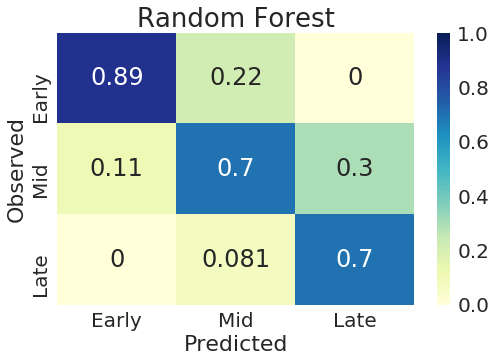

Precision Random Forest 0.763863863864
Classification Random Forest
             precision    recall  f1-score   support

          0       0.89      0.50      0.64        16
          1       0.70      0.87      0.78        30
          2       0.70      0.70      0.70        10

avg / total       0.76      0.73      0.72        56



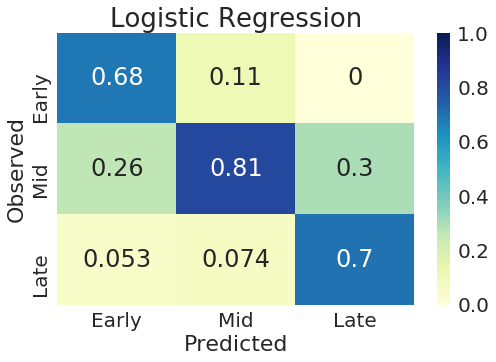

Precision Logistic Regression 0.733008447044
Classification Logistic Regression
             precision    recall  f1-score   support

          0       0.68      0.81      0.74        16
          1       0.81      0.73      0.77        30
          2       0.70      0.70      0.70        10

avg / total       0.76      0.75      0.75        56



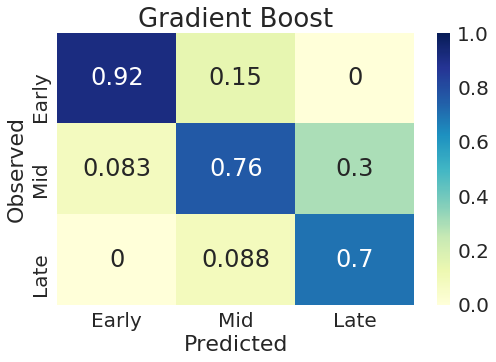

Precision Gradient Boost 0.793790849673
Classification Gradient Boost
             precision    recall  f1-score   support

          0       0.92      0.69      0.79        16
          1       0.76      0.87      0.81        30
          2       0.70      0.70      0.70        10

avg / total       0.80      0.79      0.78        56



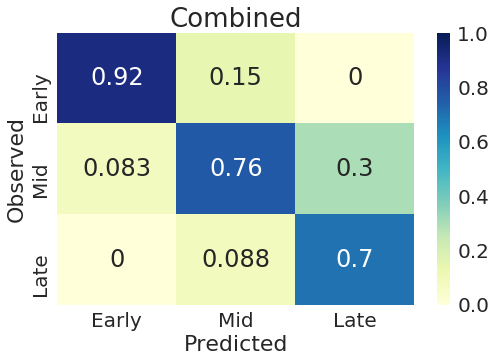

Precision Combined 0.793790849673
Classification Combined
             precision    recall  f1-score   support

          0       0.92      0.69      0.79        16
          1       0.76      0.87      0.81        30
          2       0.70      0.70      0.70        10

avg / total       0.80      0.79      0.78        56



In [104]:
X_test_s = selector.transform(X_test)
for clf, label in zip([clf1, clf2, clf3, eclf], ['Random Forest', 'Logistic Regression', 
                                           'Gradient Boost', 'Combined']):
    clf.fit(X_train_s, y_train)
    pred = clf.predict(X_test_s)
    conf_matrix = confusion_matrix(y_test, pred)
# try different plots of the confusion matrix
    norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
    plt.figure(figsize=(8,5))
    sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Mid', 'Late'],
           yticklabels = ['Early', 'Mid', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.title(label, fontsize=26)
    plt.show()
    print('Precision '+label, + precision_score(y_test, pred, average = 'macro'))
    print('Classification '+label + '\n'+ classification_report(y_test, pred))

## KNB param_dist

param_grid = {'n_neighbors':[5,10,20], 'weights':['uniform', 'distance'],
              'metric':['euclidean', 'manhattan', 'minkowski']
             }

kn = KNeighborsClassifier(n_jobs=-1)

kn_search_param = GridSearchCV(kn,param_grid=param_grid,
                                   scoring='precision_macro',n_jobs=6,iid=False,
                                   cv=5)
kn_search_param.fit(X_train_s, y_train)
print(kn_search_param.best_params_)
print(kn_search_param.best_estimator_)

y_pred=report_res(kn_search_param, X_train_s, y_train, 'macro')